In [1]:
from fastai.vision.all import *

# Multi-Label Classification

## Data

In [2]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/storage/data/pascal_2007/valid.json'),Path('/storage/data/pascal_2007/test.csv'),Path('/storage/data/pascal_2007/train.json'),Path('/storage/data/pascal_2007/segmentation'),Path('/storage/data/pascal_2007/test'),Path('/storage/data/pascal_2007/train'),Path('/storage/data/pascal_2007/test.json'),Path('/storage/data/pascal_2007/train.csv')]

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Deeper dive into datablock

In [4]:
dblock = DataBlock()
dsets = dblock.datasets(df)

dsets.train[0]

(fname       000874.jpg
 labels          person
 is_valid          True
 Name: 433, dtype: object,
 fname       000874.jpg
 labels          person
 is_valid          True
 Name: 433, dtype: object)

###### x and y:

In [5]:
dblock = DataBlock(get_x=lambda r: r['fname'], get_y=lambda r: r['labels'].split(' '))
dsets = dblock.datasets(df)

dsets.train[0]

('002102.jpg', ['bird'])

###### Categories:

In [6]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
    get_x=lambda r: (path/'train')/r['fname'],
    get_y=lambda r: r['labels'].split(' '))

dsets = dblock.datasets(df)

dsets.train[0]

(PILImage mode=RGB size=360x270,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.]))

In [7]:
dsets.train.vocab

(#20) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow'...]

In [8]:
idx = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idx]

(#1) ['sofa']

###### Validation set

In [9]:
def splitter(df):
    train = df.index[~df.is_valid].tolist()
    valid = df.index[df.is_valid].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
    get_x=lambda r: (path/'train')/r['fname'],
    get_y=lambda r: r['labels'].split(' '),
    splitter=splitter)

dsets = dblock.datasets(df)

dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

###### Finally: DataLoaders

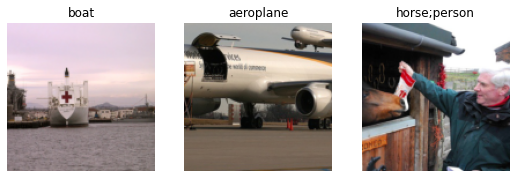

In [10]:
def splitter(df):
    train = df.index[~df.is_valid].tolist()
    valid = df.index[df.is_valid].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
    get_x=lambda r: (path/'train')/r['fname'],
    get_y=lambda r: r['labels'].split(' '),
    splitter=splitter,
    item_tfms=RandomResizedCrop(128, min_scale=.35))

dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

# Loss function

In [15]:
learn = cnn_learner(dls, resnet18)
learn.model = learn.model.to('cuda')

To figure out how a loss function should look like, look at example activations.

In [16]:
xb, yb = dls.train.one_batch()

activations = learn.model(xb)
activations.shape

torch.Size([64, 20])

Batch size of 64, predictions for each of the 20 categories. Predictions are not normalized, as the interpretation as 'probability' does not make sense in this scenario.

In [26]:
act = activations[0]
target = yb[0]
act

tensor([ 0.3536, -0.4001, -1.0034, -1.0824,  0.3400,  2.6216,  2.1170, -0.0635, -0.7779,  0.0250,  0.2922, -3.2975,  6.8198, -0.4855, -0.3848, -0.4705,  3.5386,  1.1862, -1.5371,  1.2641],
       device='cuda:0', grad_fn=<SelectBackward>)

In [28]:
pos = torch.sigmoid(act)
loss = -torch.where(target==1, pos, 1-pos)
loss

tensor([-0.4125, -0.5987, -0.7317, -0.7470, -0.4158, -0.0678, -0.1075, -0.5159, -0.6852, -0.4937, -0.4275, -0.9643, -0.9989, -0.6191, -0.5950, -0.6155, -0.0282, -0.2339, -0.8230, -0.2203],
       device='cuda:0', grad_fn=<NegBackward>)

In [29]:
def binary_cross_entropy_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [31]:
binary_cross_entropy_loss(activations, yb)

tensor(1.1067, device='cuda:0', grad_fn=<NegBackward>)

PyTorch Version. This is used by default by fastai when MultiCategory block is used.

In [34]:
loss_func = nn.BCEWithLogitsLoss()
loss_func(activations, yb)

tensor(1.1067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

Metrics need to be tweaked a bit:

In [35]:
def multi_accuracy(inputs, targets, threshold=.5, sigmoid=True):
    if sigmoid: inputs = inputs.sigmoid()
    return ((inputs>=threshold)==targets).float().mean()

In [36]:
multi_accuracy(activations, yb)

TensorMultiCategory(0.4828, device='cuda:0')

In [38]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.955448,0.708551,0.235398,00:12
1,0.832851,0.553697,0.297968,00:11
2,0.611813,0.207531,0.807550,00:11
3,0.366077,0.124706,0.940458,00:10


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133846,0.117033,0.947849,00:12
1,0.115665,0.107503,0.951036,00:12
2,0.097415,0.104042,0.951594,00:12
